# Tutorial: Dimensional Reduction and Clustering
BSc ML in Physics & Astronomy course, Sep 2021

Author: Ryan van Mastrigt

In this tutorial we will use dimensional reduction techniques, specifically PCA and t-SNE, to reduce high dimensional data to two dimensions such that the data can be easily visualized. Next, clustering techniques can be used on the reduced data to find ordering in the data. In this tutorial we will work with Monte Carlo-generated spin configurations for the two-dimensional Ising model on a square lattice over a range of temperatures. This model is known to have a phase transition from an ordered to a disorded state at $T_c = \frac{2 J}{k \ln{(1 + \sqrt{2})}}$. In the data we use $J = k = 1$.

## Initialization
First things first, we need to load in the packages we will use throughout this tutorial. Additionally we will load in the Ising data. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

data = np.load('tutorial4_data/MC_Ising_2Dsquare_10x10.npz')

## Exercise 1 - PCA on the Ising model
Note that the loaded data has a .npz file format; this is Numpy's file format for a zipped archive of files. First we will explore the data a bit.

In [9]:
# To see the files in the zipped archive, use .files extention
data.files

['configs', 'temperatures']

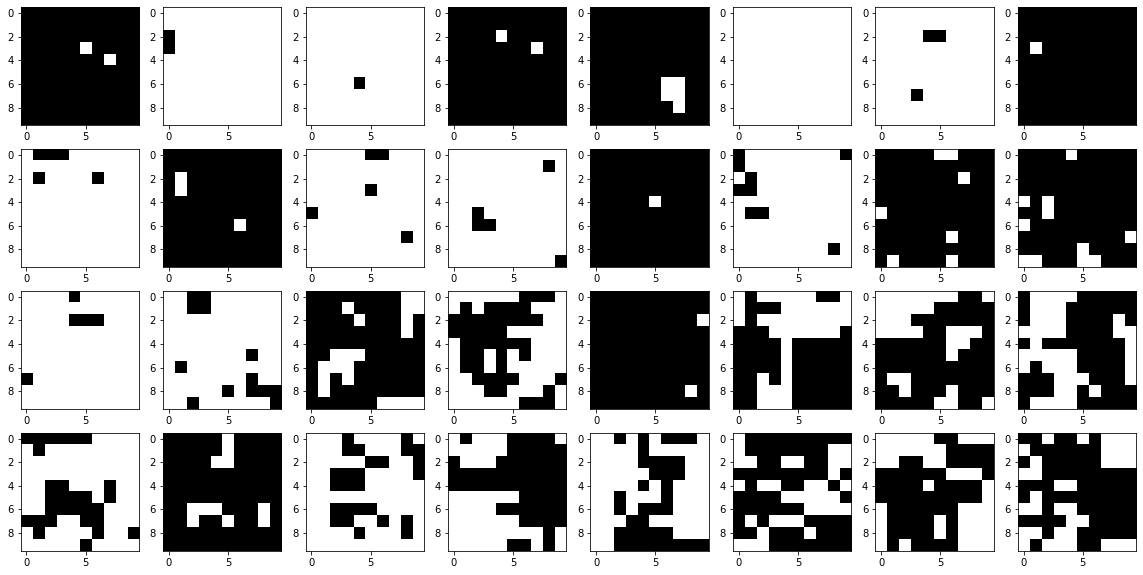

In [10]:
configs = data['configs']
T = data['temperatures']

#For every unique temperature, plot a random image from the configs
plt.figure(figsize=(20, 10))
for i in range(np.shape(T)[0]):
    j = np.random.randint(0, np.shape(configs)[1])
    plt.subplot(4, 8, i+1)
    plt.imshow(configs[i, j], cmap='Greys', vmin=-1, vmax=1)


## Task A) The order parameter
Do you see what changes in the configurations when the temperature is increased? Can you think of a parameter that would capture these changes in a single value? Does this parameter have any physical meaning?

A1: It looks like the more the temperature increases, the higher the entropy/disorderedness gets. Thus we see more equal distribution in spin configuration as opposed to one spin dominating.
A2: The total magnetization could give a good idea of the amount of 'chaos'
A3: Yes it has physical meaning; it says a lot about the (potential) energy captured in the system

## Physical quantities of the Ising model
The Ising model in its most simple form is described by the Hamiltonian $H=-J \sum_{(i, j)} s_i s_j$, where $s_i \in \{-1, +1\}$ is the spin on site $i$, and $(i, j)$ indicates a sum over nearest neighbours. From the configurational data, we are able to define multiple physical quantities of the system as a function of temperature. 

Text(0.5, 1.0, 'Magnetic susceptibility')

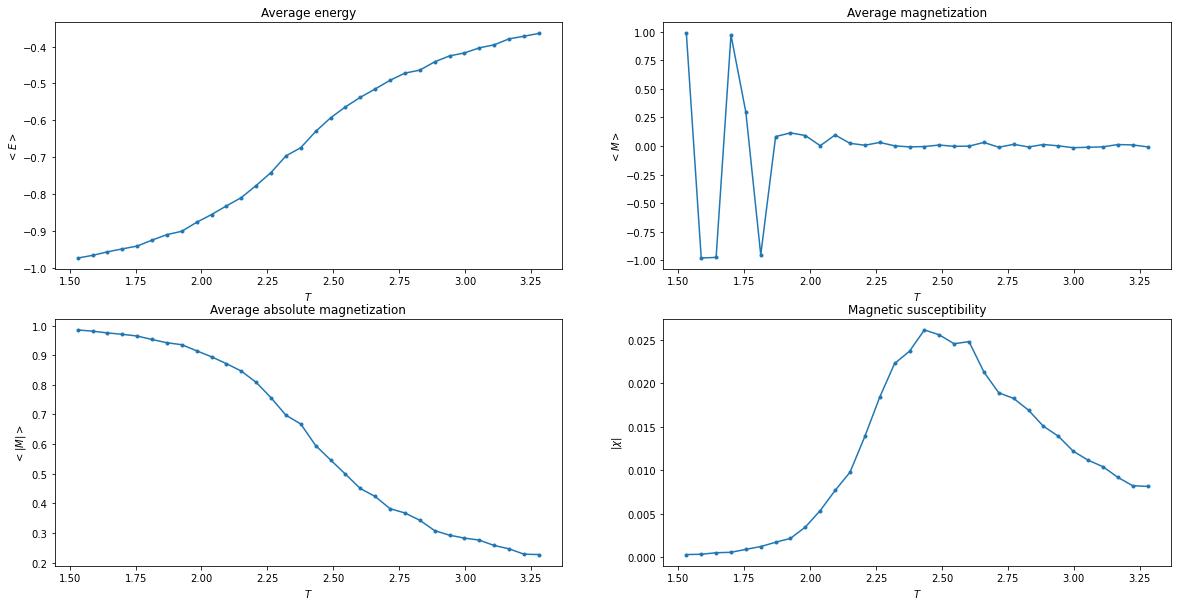

In [11]:
def calc_magnetization_and_susceptibility(configs):
    # the magnetization per configuration is given by the sum of all spins, here we take the absolute magnetization
    # sum over each configuration and normalize
    Mag = np.sum(configs, axis=(2, 3))
    Mag = np.divide(Mag, np.shape(configs)[2] * np.shape(configs)[3])
    AbsMag = np.abs(Mag)
    MagSq = np.square(AbsMag)
    #sum over configs per temperature
    Mag = np.sum(Mag, axis=1) / np.shape(configs)[1]
    AbsMag = np.sum(AbsMag, axis=1) / np.shape(configs)[1]
    MagSq = np.sum(MagSq, axis=1) / np.shape(configs)[1]
    Chi = np.divide(np.add(MagSq, -np.square(AbsMag)), T)
    return Mag, AbsMag, Chi

def calc_energy(configs):
    # the energy per configuration can be determined from the Hamiltonian
    Energy = np.zeros(np.shape(configs)[0])
    for t in range(np.shape(configs)[0]):
        En = 0
        for c in range(np.shape(configs)[1]):
            # For each configuration, calculate the energy by multiplying each site with its 
            # horizontal and vertical nearest neighbour and summing the total
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=0)))
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=1)))
        En /= 2 * np.shape(configs)[1] * np.shape(configs)[2] * np.shape(configs)[3]
        Energy[t] = En
    return Energy

Mag, AbsMag, Chi = calc_magnetization_and_susceptibility(configs)
Energy = calc_energy(configs)

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(T, Energy, '.-')
plt.xlabel('$T$')
plt.ylabel('$<E>$')
plt.title('Average energy')

plt.subplot(2, 2, 2)
plt.plot(T, Mag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<M>$')
plt.title('Average magnetization')

plt.subplot(2, 2, 3)
plt.plot(T, AbsMag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<|M|>$')
plt.title('Average absolute magnetization')

plt.subplot(2, 2, 4)
plt.plot(T, Chi, '.-')
plt.xlabel('$T$')
plt.ylabel('$|\chi|$')
plt.title('Magnetic susceptibility')


## Task B) The magnetization
The average magnetization $\langle M \rangle$ seems to switch from -1 to 1 at low temperatures. Can you give an explenation of why this might be happening? Do you think this comes from the numeric technique used to generate the data (Metropolis algorithm) or does it portray physical behaviour inherent to the model?


A: I think it very well demonstrates the nature of a low-temperature system - which prefers a large total magnetization as there is little kinetic energy to bridge the gap of oppoising magnetization with nearest neighbors.

## PCA
If we would want to display each configuration as a datapoint in phase space, we would need a $10 \times 10 = 100$ dimensional image. Unsurprisingly, this is quite difficult to visualise. Dimensional reduction techniques can come in handy to help visualise your data and find trends. Onse such simple and effective dimensional reduction technique is Principle Component Analysis, or PCA. In what follows we will derive PCA in a general case, after which you will write code for applying it to the Ising model data.

Suppose we have a $n \times p$ data matrix $X$, where each of the $n$ rows represents a unique measurement of all the $p$ features. For what follows, we assume the mean of each column has been shifted to zero. We are then looking for a set of a given size, say $l$, of $p$-dimensional vectors $w_{(k)} = (w_1, ..., w_p)_{(k)}$ that map each row vector $x_{(i)}$ of $X$ to a new vector of principal component scores $t_{(i)} = (t_1, ..., t_l)_{(i)}$, which are calculated as
\begin{equation}
    t_{k(i)} = x_{(i)} \cdot w_{(k)}, \quad \mathrm{for} \quad i=1, ..., n \quad k=1, ..., l.
\end{equation}
Such that the components of $t$ successively have the maximum possible variance from $X$, and where $w$ is constrained to be a unit vector.

For our data matrix, we can then define the empirical covariance matrix as
\begin{equation}
    Q = X^T X.
\end{equation}
Since we want to find the largest value for the first component of $t$, this equates to finding
\begin{equation}
    w_{(1)} = \mathrm{arg max} \sum_i (t_1)^2_{(i)} = \mathrm{arg max}\frac{w^T Q w}{w^T w},
\end{equation}
which can be recognised as the Rayleigh quotient. For a positive semidefinite matrix like $Q$ the quotient's maximum possible value is the largest eigenvalue of the matrix, so $w$ needs to be the corresponding eigenvector.

To find the other principal components, note that the covariance matrix can be written as
\begin{equation}
    Q = W \Lambda W^T,
\end{equation}
where W is a $p \times p$ matrix whose columns are the eigenvectors of $Q$, and $\Lambda$ is the diagonal matrix of eigenvalues $\lambda_{(k)}$ of $Q$.
The covariance matrix between the principal components then becomes
\begin{equation}
    W^T Q W = W^T W \Lambda W^T W = \Lambda.
\end{equation}
$\lambda_{(k)}$ is equal to the sum of the squares over the dataset associated with each component $k$: 
\begin{equation}
    \lambda_{(k)} = \sum_i (t_k^2)_{(i)} = \sum_i (x_{(i)} \cdot w_{(k)})^2.
\end{equation}
In summary, the principal components are eigenvectors of the data's covariance matrix, and the top principal components correspond to the directions in the data-space that preserve as much of the data's variation as possible.

## Task C) Set up PCA on the Ising data
Use numpy to set up PCA on the Ising data, and plot the data onto the first two principle components. How much variance can be explained with the first two components? Can you see to which physical quantity the first principle component relates?

In [37]:
# First transform the data to a n by p matrix
configs_PCA = np.reshape(configs, (-1, np.shape(configs)[2] * np.shape(configs)[3]))

# Shift the data such that the mean of each column has been shifted to zero 
# and normalize such that they have the same standard deviation

shape_PCA = np.shape(configs_PCA)
n = shape_PCA[1]
p = shape_PCA[0]
for x in range(p - 1):
    col_avg = 0
    for y in range(n - 1):
        col_avg += configs_PCA[x][y] / n
    for y in range(n - 1):
        configs_PCA[x][y] -= col_avg

# calculate the covariance matrix (tip: use numpy's built in functions)
cov_mat = np.cov(configs_PCA)

# Find the eigendecomposition of the covariance matrix
## enter code ##

# Visualize the eigenvalues from high to low
## enter code ##

# Project the data onto the first two principal components and plot the results 
# (tip: try colouring each configuration with a unique colour per temperature)
## enter code ##

# Take the average per temperature of the absolute value over the projected data for the first two components
# and plot as a function of temperature. Which physical quantities do the components resemble?

## Task D) Plot the Principal components
One of the advantages of a linear technique like PCA, is that it is interpretable. The principle components have a clear relationship to the original data. It can be useful to plot the components to see what exactly they do. Since the original data is two-dimensional, it makes sense to transform the principal components to 2D as well to see how they work on each part of the lattice. Please plot the two principle components. Can you see what the second principle component looks at? Tip: Fourier transformations.

In [ ]:
# transform the principal components to two dimensions
# eigen_vectors are the principle components, and is of shape (p, l)
eigen_vectors = 
PC_transformed = np.reshape(eigen_vectors, (np.shape(configs)[2], np.shape(configs)[3], np.shape(eigen_vectors)[1]))

# plot the results
vmin = np.amin(eigen_vectors[:, 0:2])
vmax = np.amax(eigen_vectors[:, 0:2])
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
plt.imshow(PC_transformed[:, :, 0], vmin=vmin, vmax=vmax)
plt.title('PC1')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.roll(PC_transformed[:, :, 1], 6), vmin=vmin, vmax=vmax)
plt.title('PC2')
plt.colorbar()

# Exercise 2 - K-means clustering
Next to dimensional reduction techniques, clustering techniques can be useful for identifying similar datapoints and grouping them accordingly. In what follows, you will apply K-means clustering to the PCA-projected Ising data after a brief theoretical introduction to the technique.

If we again assume we have a $n \times p$ data set  $X$, k-means clustering tries to partition the $n$ observations into $k$ (to be defined by the user) sets $S = \{S_1, S_2, ..., S_k\}$ such that the within-cluster variance is minimized. More formally this can be expressed as:
\begin{equation}
    \mathrm{arg min}_S \sum_{i=1}^{k} \sum_{x \in S_i} ||x - \mu_i||^2 = \mathrm{arg min}_S \sum_{i=1}^{k} |S_i| \mathrm{Var}S_i,
\end{equation}
where $\mu_i$ is the mean of all points in $S_i$.

In its most naive form, the solution to this problem can be approximated through an iterative algorithm. 

Given a set of means $m_1^{(1)}, ..., m_k^{(1)}$ the algorithm first assigns each observation to the cluster with the nearest (in Euclidian distance) mean. The means are then updated as
\begin{equation}
    m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|} \sum_{x_j \in S_i^{(t)}} x_j.
\end{equation}
This process repeats itself until the means converge. However, this algorithm is not guaranteed to find the optimum.

There are multiple ways of chosing the initial means, that can have a large effect on the effectiveness of the method. Here we will use the so-called k-means++ approach. The algorithm goes as follows:
1. Choose the first cluster center uniformly at random from all the data points.
2. For each data point $x$ not chosen yet, compute D(x): the distance between x and the nearest center.
3. Chose one new data point at random as a new center, using a weighted probability distribution where point $x$ is weighted proportional to $D(x)^2$.
4. Repeat steps 2 and 3 until $k$ centers have been chosen.
5. Proceed to normal k-means clustering.

For this assignment, please finish the code below to complete the k-means algorithm. 
1. Show the sum of squared error as a function of number of iterations. 
2. How fast do you converge to a solution? 
3. Does this change if you initialize your clusters at random instead of with k-means++?
4. Plot each cluster with a different colour in a scatter plot. Does the clustering make sense to you? 
5. What is a natural number of clusters for this dataset?

In [ ]:
# some helper functions
# initialize your data (in this case, first two projected PCA components)
# Proj is the Ising data projected along the principle components, of shape (n, l)
Proj = 
kdat = Proj[:, 0:2]
# set k
k = 

# array to store centroids
centroids = np.zeros((k, np.shape(kdat)[1]))

# k-means++ initialization
# array to store distance each datapoint to each centroid
dist = np.zeros((k, np.shape(kdat)[0]))

# sample initial centroids
random_index = np.random.randint(np.shape(kdat)[0])
centroids[0] = kdat[random_index]
d = np.add(kdat, -centroids[0])
d = np.square(d)
d = np.sum(d, axis=1)
dist[0] = d
prob = dist[0] / np.sum(dist[0])
random_index = np.random.choice(np.shape(kdat)[0], p = prob)
for i in range(1, k):
    centroids[i] = kdat[random_index]
    d = np.add(kdat, -centroids[i])
    d = np.square(d)
    d = np.sum(d, axis=1)
    dist[i] = d
    prob = np.amin(dist[:i+1], axis=0)
    prob /= np.sum(prob)
    random_index = np.random.choice(np.shape(kdat)[0], p = prob)

# list of the sum of squared estimated of errors to keep track during k-means
sse_list = []

# function to compute the L2 distance between data x of form [n, p] and centroid of form [p]
def compute_l2_distance(x, centroid):
    dist = ((x - centroid) ** 2).sum(axis = 1)
    return dist

# function that finds the closest centroid for data x of form [n, p] and set of centroids of form [k, p]
def get_closest_centroid(x, centroids):
    dist = []
    for c in range(len(centroids)):
        dist.append(compute_l2_distance(x, centroids[c]))
    closest_centroid_index = np.argmin(np.array(dist), axis=0)
    return closest_centroid_index

# compute the sum of squared errors for a given dataset, list of centroids 
# and list of which centroid each datapoint is assigned to
def compute_sse(data, centroids, assigned_centroids):
    # compute SSE
    sse = np.square(np.add(data, -centroids[assigned_centroids])).sum() / len(data)
    return sse


num_iters = 10

## write k-means loop

## plot the results (colour each cluster differently)

# Exercise 3 - t-SNE


While both PCA and k-means have proven to be excellent techniques for dimension reduction and clustering, their simplicity, while allowing for interpretability, can also be limiting. Since PCA is a strictly linear technique, higher order correlations and complex structure in data can not always be captured by PCA. One technique which does allow for more complex structures in the data to be used, is t-distributed stochastic neighbour embedding, or t-SNE for short. This technique is a nonlinear dimensionality reduction technique typically used for embedding high-dimensional data for visualisation in low-dimensional spaces (2 or 3 dimensions).

In short, the t-SNE algorithm works by assigning a Gaussian probability distribution over the high-dimensional space based on the Euclidian distance between samples, where similar samples are assigned a higher probability, and dissimilar objects a lower probability. Likewise, a probability distribution is assigned over the low-dimensional space (which we're trying to find). The algorithm then minimises the Kullback-Leibler divergence (KL divergence: a measure for how close two probability distributions are) between the two distributions with respect to the locations of the lower-dimensional points. Other metrics than the Euclidian distance can be used in the probability distributions, and may be more appropriate depending on the problem.

In more detail, if we have a set of $n$ high-dimensional samples $x_1, ..., x_n$, t-SNE first computes the probabilities $p_{ij}$ that are proportional to the similarity of the samples $x_i$ and $x_j$:
\begin{equation}
    p_{j | i} = \frac{\exp{(-||x_i - x_j||^2 / 2 \sigma_i^2)}}{\sum_{k \neq i} \exp{(-||x_i - x_k||^2 / 2 \sigma_i^2)}},
\end{equation}
where we explicitely set $p_{i | i} = 0$. $\sigma_i$ is the bandwith of the Gaussian kernel, and is adapted to the density of the data. The more dense the data, the smaller $\sigma_i$. Note that $\sum_j p_{j | i} = 1$ for all $i$. This conditional probability can be understood as the probability that $x_i$ would pick $x_j$ as its neighbour if neighbours were picked in proportion to their probability density under a Gaussian centered at $x_i$.

We can now define the probability
\begin{equation}
    p_{ij} = \frac{p_{j | i} + p_{i | j}}{2 n},
\end{equation}
note that this probability is symmetric, $p_{i i} = 0$, and $\sum_{i, j} p_{i j} = 1$. This is then the probability function over the high-dimensional space.

The aim of t-SNE is to learn a lower $d$-dimensional representation $y_1, ..., y_n$, with $d$ typically 2 or 3, that reflects $p_{ij}$ as well as possible, i.e. it tries to keep samples similar in the high-dimensional space also close in the low-dimensional space. For this, t-SNE defines another probability distribution over the low-dimensional space:
\begin{equation}
    q_{i j} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_k \sum_{l \neq k} (1 + ||y_k - y_l||^2)^{-1}},
\end{equation}
and again we set $q_{ii} = 0$. 

The locations of $y_i$ are then determined by minimising the KL divergence of the distribution $P$ from the distribution $Q$:
\begin{equation}
    \mathrm{KL}(P || Q) = \sum_{i \neq j} p_{ij} \log{\frac{p_{ij}}{q_{ij}}}.
\end{equation}
The KL divergence is minimised using gradient descent. 

Implementation from scratch is a bit too involved for this course, so instead we will use a readily available implemenetation from the Scikit package. Apply t-SNE to the Ising data and play with the available parameters. What do you see?
Note: running TSNE might take a while, you can reduce the amount of samples to speed it up (be sure to include samples from all temperatures!)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose = 1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(configs_PCA)

In [ ]:
plt.figure(figsize=(16, 10))
color = plt.cm.coolwarm(np.linspace(0.,1.,len(T)))
for t in range(len(T)):
#     plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    x = tsne_results[1024*t:1024*(t+1), 0]
    y = tsne_results[1024*t:1024*(t+1), 1]
    plt.plot(x, y, '.', color=color[t])
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()